# Visualize Model Predictions

In [1]:
import json
import sys
import os
from pathlib import Path
import h5py

import numpy as np
import matplotlib.pyplot as plt
import torch

# Import model architecture.
CWD = os.path.join(Path().resolve())
sys.path.append(os.path.abspath(os.path.join(CWD, '..', 'training')))
from models import build_model

In [7]:
# Specify job_id and hyperparamter config id.
config_id = "default"
job_id = 1

# Path to model weights and config file.
job_dir = os.path.abspath(os.path.join(
    CWD, "../trained_models/{0:}/{1:05g}".format(config_id, job_id)
))

# Load config file.
with open(os.path.join(job_dir, 'config.json')) as f:
    CONFIG = json.load(f)

CONFIG["ARCHITECTURE"] = "GerbilizerDenseNet"

# Load model.
model, _ = build_model(CONFIG)
# model.load_state_dict(torch.load(os.path.join(job_dir, "init_weights.pt")))
model.load_state_dict(torch.load(os.path.join(job_dir, "best_weights.pt")))
model.eval();

# Specify data file.
data_dir = os.path.abspath(os.path.join(CWD, "../data"))
data_file = h5py.File(os.path.join(data_dir, "train_set.h5"))

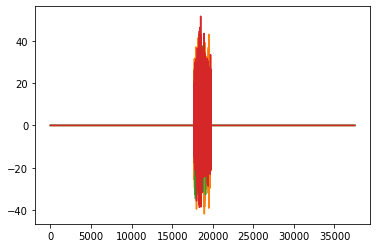

In [8]:
# Plot example vocalization
plt.plot(data_file["vocalizations"][np.random.randint(100)].T)

In [9]:
def compute_model_prediction(idx):
    audio_inputs = torch.from_numpy(data_file["vocalizations"][idx][None, :, :])
    with torch.no_grad():
        return model(audio_inputs)[0].numpy()

def plot_model_prediction(idx):
    targ = data_file["locations"][idx]
    x, y = targ[:, :, 0], targ[:, :, 1]
    pred = compute_model_prediction(idx)
    xhat, yhat = pred[:, :, 0], pred[:, :, 1]
    for c, color in enumerate(("r", "g", "b")):
        plt.scatter(x[:, c], y[:, c], edgecolors=color, facecolors='none', s=100)
        plt.scatter(xhat[:, c], yhat[:, c], color=color, marker="+")
        
    plt.xlim([-.3, .3])
    plt.ylim([-.3, .3])
    plt.title(idx)

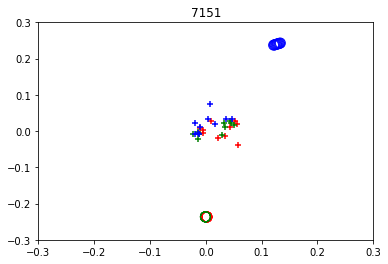

In [31]:
# plot_model_prediction(np.random.randint(10000))
plot_model_prediction(sorted_idx[5])

In [24]:
from scipy.spatial.distance import pdist
meanlocs = np.array(data_file["locations"]).mean(axis=1)
maxdists = []
for i, M in enumerate(meanlocs):
    maxdists.append(pdist(M).max())
sorted_idx = np.argsort(maxdists)[::-1]